# Santander-customer-transaction-classification-problem

 In this project, I have addressed Santander customer transaction classification problem, The aim of the project is to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted.

In [40]:
# loading Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import binarize
from sklearn import metrics
from sklearn.metrics import precision_score ,recall_score


Setting Working directory

In [2]:
os.chdir("C:\\Users\\kumarvch\\Desktop\\Data_aNALYSIS\\ds Project\\santander Prject")

Reducing Menory:
    
    Since the dataset contains 0.2Million sample and 200 observations. the file size will be very high.
    we can reduce the unwanted memory used by the data, By optimizing the memory allocation

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [74]:
np.iinfo(np.int8).min

-128

In [4]:
train = import_data("C:\\Users\\kumarvch\\Desktop\\Data_aNALYSIS\\ds Project\\santander Prject\\train.csv")

Memory usage of dataframe is 308.23 MB
Memory usage after optimization is: 83.77 MB
Decreased by 72.8%


In [5]:
test= import_data("C:\\Users\\kumarvch\\Desktop\\Data_aNALYSIS\\ds Project\\santander Prject\\test(1).csv")

Memory usage of dataframe is 306.70 MB
Memory usage after optimization is: 83.58 MB
Decreased by 72.7%


In [6]:
print(train.shape , test.shape)

(200000, 202) (200000, 201)


# Missing Value Aanalysis

In [7]:
missing_data_train = pd.DataFrame(train.isnull().sum())
missing_data_test = pd.DataFrame(test.isnull().sum())

In [8]:
missing_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202 entries, ID_code to var_199
Data columns (total 1 columns):
0    202 non-null int64
dtypes: int64(1)
memory usage: 13.2+ KB


In [9]:
missing_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 201 entries, ID_code to var_199
Data columns (total 1 columns):
0    201 non-null int64
dtypes: int64(1)
memory usage: 13.1+ KB


*There are no missing Values in the dataset

In [10]:
train

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.921875,-6.785156,11.906250,5.093750,11.460938,-9.281250,5.117188,18.625000,...,4.433594,3.964844,3.136719,1.691406,18.515625,-2.398438,7.878906,8.562500,12.781250,-1.091797
1,train_1,0,11.500000,-4.148438,13.859375,5.390625,12.359375,7.042969,5.621094,16.531250,...,7.640625,7.722656,2.583984,10.953125,15.429688,2.033203,8.125000,8.789062,18.359375,1.952148
2,train_2,0,8.609375,-2.746094,12.078125,7.894531,10.585938,-9.085938,6.941406,14.617188,...,2.906250,9.789062,1.669922,1.685547,21.609375,3.142578,-6.519531,8.265625,14.718750,0.396484
3,train_3,0,11.062500,-2.152344,8.953125,7.195312,12.585938,-1.835938,5.843750,14.921875,...,4.464844,4.742188,0.717773,1.421875,23.031250,-1.270508,-2.927734,10.289062,17.968750,-9.000000
4,train_4,0,9.835938,-1.483398,12.875000,6.636719,12.273438,2.449219,5.941406,19.250000,...,-1.490234,9.523438,-0.150757,9.195312,13.289062,-1.511719,3.925781,9.500000,18.000000,-8.812500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.484375,-0.495605,8.265625,3.513672,10.343750,11.609375,5.671875,15.148438,...,6.140625,13.234375,3.990234,0.938965,18.031250,-1.793945,2.166016,8.531250,16.671875,-17.859375
199996,train_199996,0,4.914062,-2.449219,16.703125,6.632812,8.312500,-10.562500,5.878906,21.593750,...,4.960938,4.656250,0.699707,1.833984,22.265625,1.733398,-2.166016,6.742188,15.906250,0.338867
199997,train_199997,0,11.226562,-5.050781,10.515625,5.644531,9.343750,-5.410156,4.554688,21.562500,...,4.066406,5.441406,3.103516,4.878906,23.531250,-1.573242,1.283203,8.718750,13.835938,4.199219
199998,train_199998,0,9.710938,-8.609375,13.609375,5.792969,12.515625,0.533691,6.046875,17.015625,...,2.683594,8.656250,2.734375,11.117188,20.421875,-0.078613,6.796875,10.031250,15.531250,-13.898438


In [11]:
#test.drop(['ID_code'] , axis=1)
train1 = train.drop(['ID_code'], axis=1)
train1 = train.drop(['target'] , axis=1)
test1 = test.drop(['ID_code'] , axis =1)

# Outlier Analysis

In [12]:
def Outliers(cnames , DF):
    for i in cnames:
        q25 , q75 = np.percentile(DF[i] , [25,75])
        iqr = q75-q25
        Min = q25-(1.5*iqr)
        Max = q75+(1.5*iqr)
        DF.loc[DF[i] <Min, :i] = np.nan
        DF.loc[DF[i] >Max, :i] = np.nan
    
    missing_data = pd.DataFrame(DF.isnull().sum())
    missing_data = missing_data.rename(columns = {0 :'percentage'})
    missing_data = missing_data['percentage']/len(DF)
    return missing_data
    

In [26]:
cnames_Train =[feature for feature in train.columns if feature != 'ID_code']
cnames_Test =[feature for feature in test.columns if feature != 'ID_code' ]

In [28]:
cnames_Train.remove('target')

In [30]:
Outliers(cnames_Train , train1)

ID_code    0.134760
var_0      0.134760
var_1      0.134335
var_2      0.134305
var_3      0.134155
             ...   
var_195    0.001475
var_196    0.000815
var_197    0.000815
var_198    0.000570
var_199    0.000100
Name: percentage, Length: 201, dtype: float64

In [31]:
Outliers(cnames_Test , test1)

var_0      0.137515
var_1      0.137025
var_2      0.137010
var_3      0.136775
var_4      0.136720
             ...   
var_195    0.001390
var_196    0.000875
var_197    0.000875
var_198    0.000620
var_199    0.000060
Name: percentage, Length: 200, dtype: float64

We found outliers and we replaced the outliers with Null values and imputed null values with median

In [32]:
train1 = train1.fillna(train1.median())

In [33]:
test1= test1.fillna(test.median())

In [34]:
Train = pd.concat([train['target'] , train1] , axis =1)

# Exploratory Data analysis

In [35]:
Test = pd.concat([test['ID_code'] , test1] , axis =1)

Target Distribution

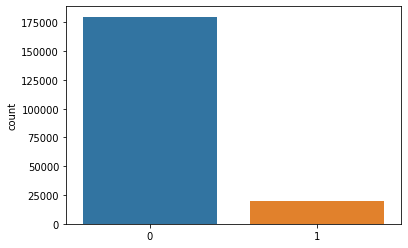

In [36]:
sns.countplot(train.target.values)

In [37]:
Train['target'].value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

In [ ]:
We can clearly see that we are dealing with an imbalanced data set.

Comparing the destribution of Features

In [41]:
def plot_and_compare(data, num):
    print('Distributions of first {} columns'.format(num))
    plt.figure(figsize=(26, 24))
    for i, col in enumerate(list(data.columns)[2:num + 2]):
        plt.subplot(math.ceil(num/4), 4, i + 1)
        plt.hist(data[col])
        plt.title(col)
    plt.show()

Distributions of first 10 columns


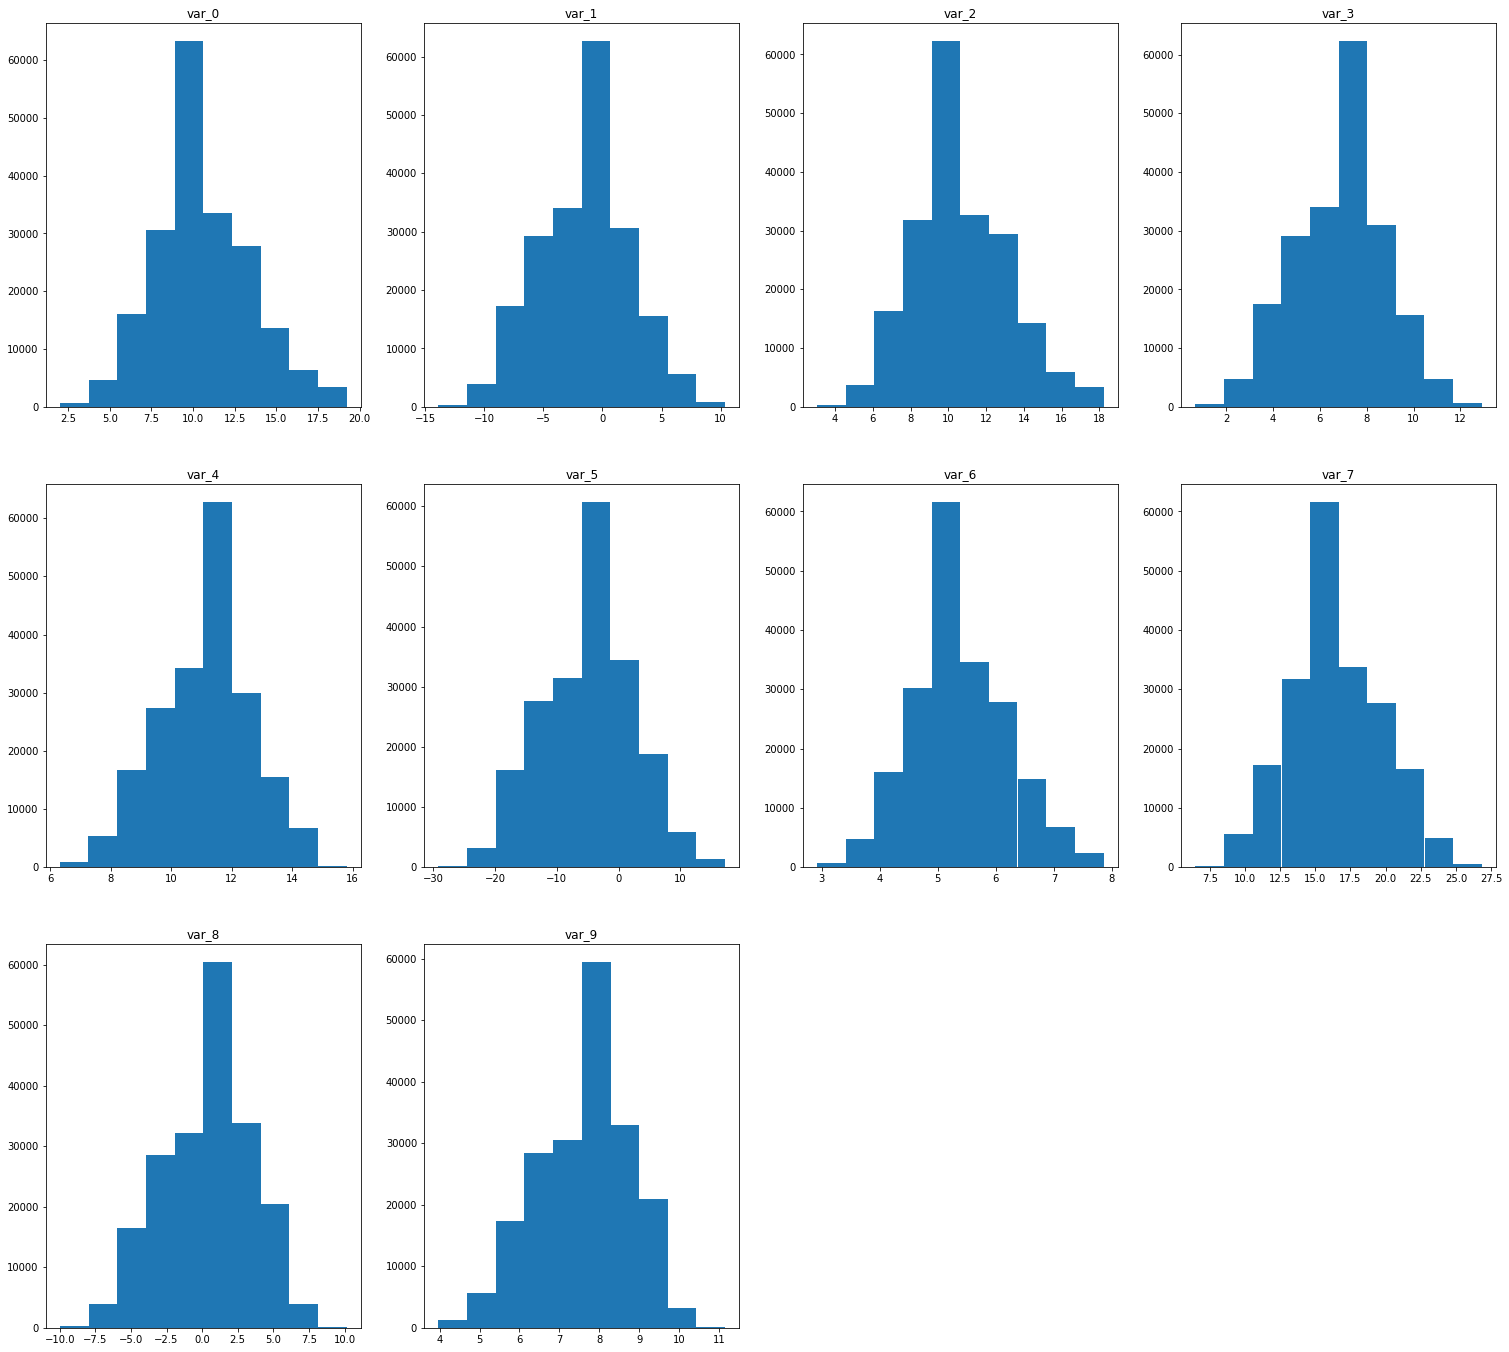

In [42]:
plot_and_compare(Train, 10)

# We can see that first 10 features have almost Normal Distribution

Distributions of first 60 columns


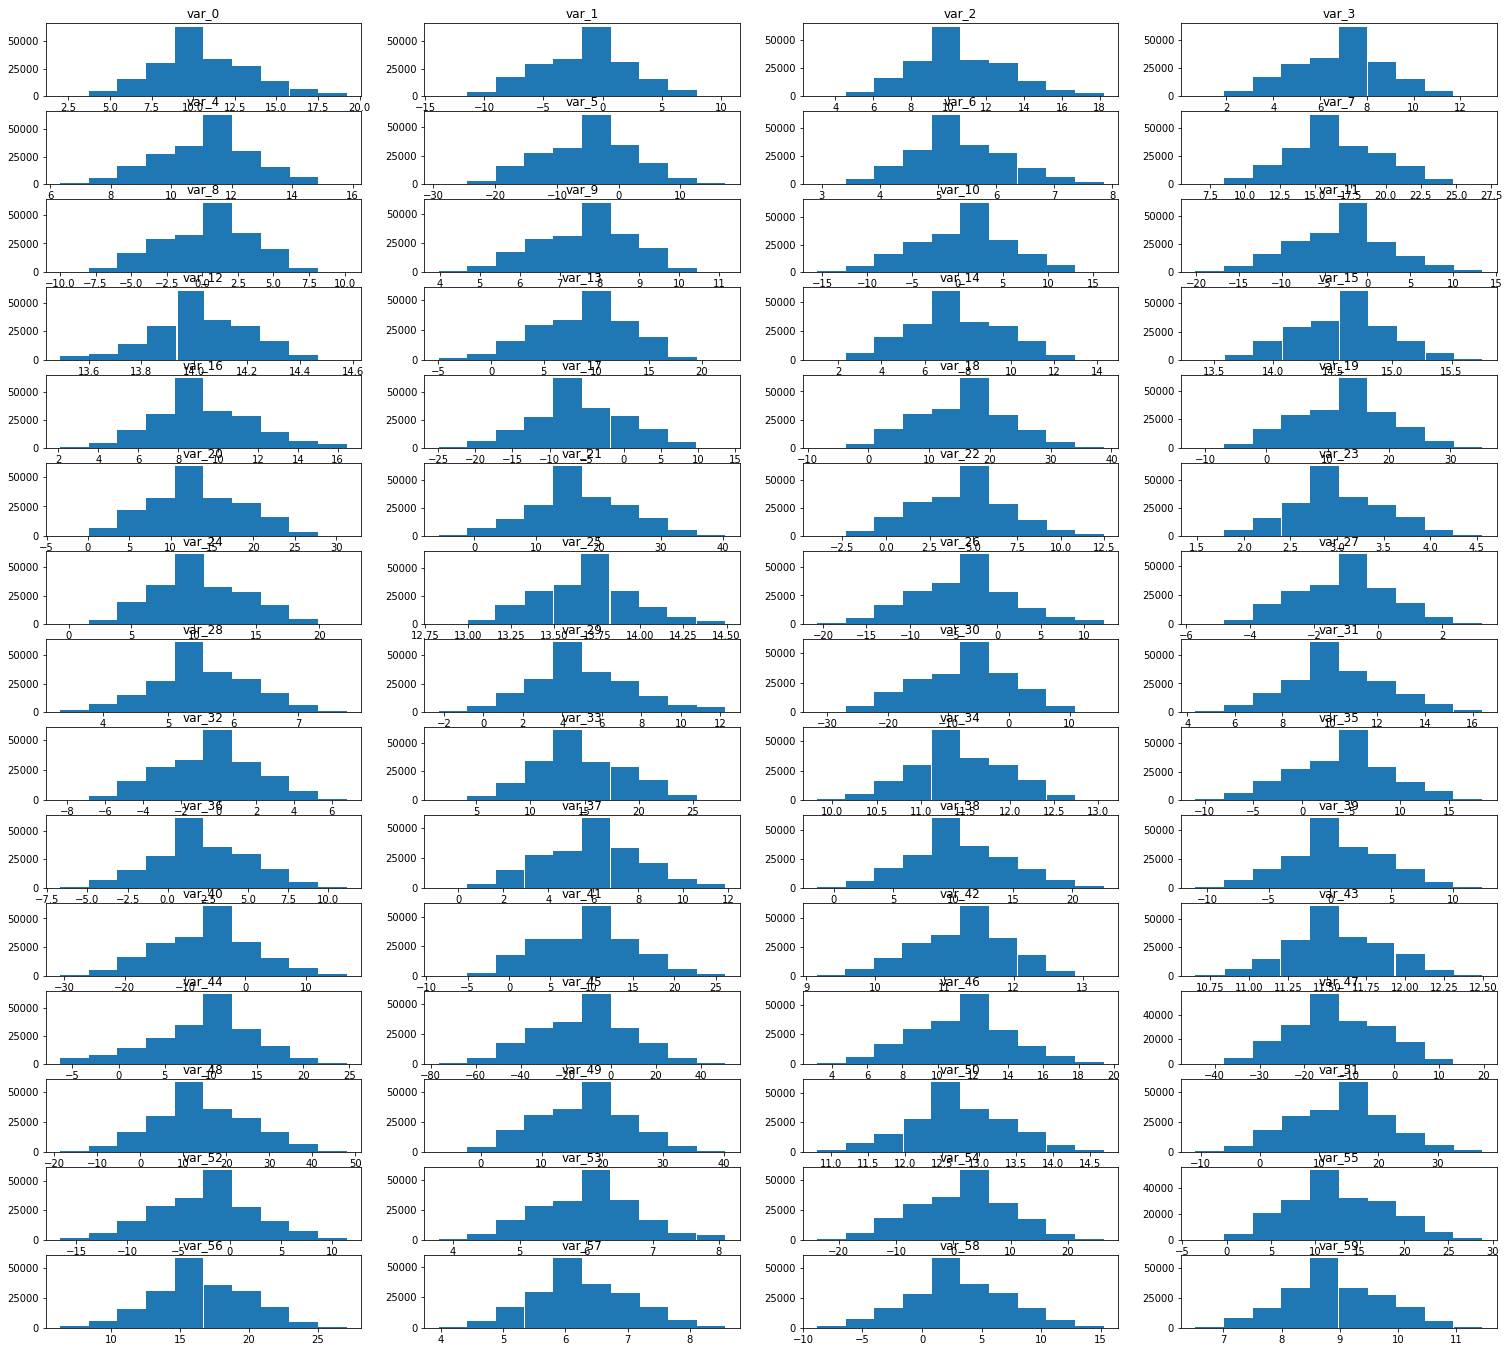

In [43]:
plot_and_compare(Train,60)

Not only they are normally distributed almost all the features have almost same distribution with same scales.

# Feature Selection

In [44]:
# def plot_corr(data):
#     data_correlation = data.corr()
#     f, ax = plt.subplots(figsize=(25, 25))
#     sns.heatmap(data_correlation,
#                 xticklabels=data_correlation.columns.values,
#                 yticklabels=data_correlation.columns.values, annot=True)
#     plt.show()

In [ ]:
# plot_corr(Train)

#We cannot make a decision of correlation by looking at the heat map and also Corr funtion is taking lot of time in loading the heat map.

Lets try Feature selection using Exhaustive Feture selection

# Exhaustive Feture selection

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# X =train.drop(['target'], axis = 1)
# y =train.target

# knn = KNeighborsClassifier(n_neighbors=3)

# efs1 = EFS(knn, 
#            min_features=1,
#            max_features=4,
#            scoring='accuracy',
#            print_progress=True,
#            cv=2)

# efs1 = efs1.fit(X, y)

# print('Best accuracy score: %.2f' % efs1.best_score_)
# print('Best subset (indices):', efs1.best_idx_)
# print('Best subset (corresponding names):', efs1.best_feature_names_)

ExhaustiveFeatureSelector is taking awfull lot of time as the number of records are 0.2 million

Lets try PCA

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:

# Principal component Analysis(PCA)

In [46]:
Train = Train.drop('ID_code' , axis = 1)

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

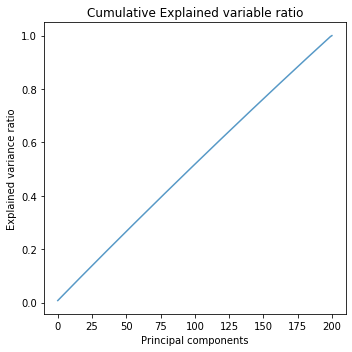

In [48]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Train)
pca = PCA()
Xtrain_transformed = pca.fit_transform(Xtrain_scaled)
sum(pca.explained_variance_ratio_[1:200])
var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(5, 5))
plt.plot(range(201), var_ratio, alpha=0.75)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Cumulative Explained variable ratio')
plt.tight_layout()

From the plot we can see that we need all 200 components to explain or to describe 100% of the data.

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
X = Train.drop(['target'] , axis=1)
y = Train.target

In [51]:
X_train , X_valid , y_train , y_valid = train_test_split(X , y ,test_size = 0.2 , random_state = 0)

In [52]:
!pip install lightgbm

In [53]:
import lightgbm as lgb

In [54]:
lgb_dataset = lgb.Dataset(X_train, label = y_train)
#lgb_dataset1 = lgb.Dataset(X, label = y  )
lgbV_dataset = lgb.Dataset(X_valid, label = y_valid, reference=lgb_dataset)
params = {}
params['learning_rate'] = 0.025
params['objective'] = 'binary'
params['boosting_type'] = 'gbdt'
params['metric'] = 'AUC'
params['max_depth'] = -1
params['feature_fraction'] = 0.04
params['min_data_in_leaf'] = 100
params['num_leaves'] = 8
#params['sub_feature'] = 0.5
#clf = lgb.cv(params,lgb_dataset1,num_boost_round = 10000,nfold=10,early_stopping_rounds=100)
clf = lgb.train(params,lgb_dataset,num_boost_round = 171,valid_sets=lgbV_dataset,early_stopping_rounds=100)

[1]	valid_0's auc: 0.566519
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.606509
[3]	valid_0's auc: 0.63673
[4]	valid_0's auc: 0.655131
[5]	valid_0's auc: 0.65753
[6]	valid_0's auc: 0.672936
[7]	valid_0's auc: 0.690714
[8]	valid_0's auc: 0.69124
[9]	valid_0's auc: 0.69532
[10]	valid_0's auc: 0.696883
[11]	valid_0's auc: 0.704885
[12]	valid_0's auc: 0.705238
[13]	valid_0's auc: 0.714889
[14]	valid_0's auc: 0.717864
[15]	valid_0's auc: 0.726894
[16]	valid_0's auc: 0.737579
[17]	valid_0's auc: 0.741182
[18]	valid_0's auc: 0.743384
[19]	valid_0's auc: 0.743979
[20]	valid_0's auc: 0.743098
[21]	valid_0's auc: 0.740122
[22]	valid_0's auc: 0.750565
[23]	valid_0's auc: 0.754281
[24]	valid_0's auc: 0.752708
[25]	valid_0's auc: 0.755742
[26]	valid_0's auc: 0.758584
[27]	valid_0's auc: 0.7572
[28]	valid_0's auc: 0.756781
[29]	valid_0's auc: 0.758955
[30]	valid_0's auc: 0.76239
[31]	valid_0's auc: 0.764259
[32]	valid_0's auc: 0.767248
[33]	valid_0's auc: 0.7702

In [55]:
Xtest  = Test.drop(['ID_code'] , axis = 1)

In [56]:
Test_prediction = clf.predict(Xtest)

In [57]:
sub = pd.DataFrame()
sub['ID_code'] = Test['ID_code']
sub['target'] = Test_prediction
sub.to_csv('results.csv', index=False)

In [58]:
Test_prediction

array([0.1154145 , 0.13395208, 0.10964975, ..., 0.07297648, 0.11290271,
       0.10327974])

In [59]:
from sklearn.metrics import roc_curve, auc

In [60]:
ypred = clf.predict(X_valid)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, ypred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8415737389818678

Text(0.5, 0, 'False Positive Rate')

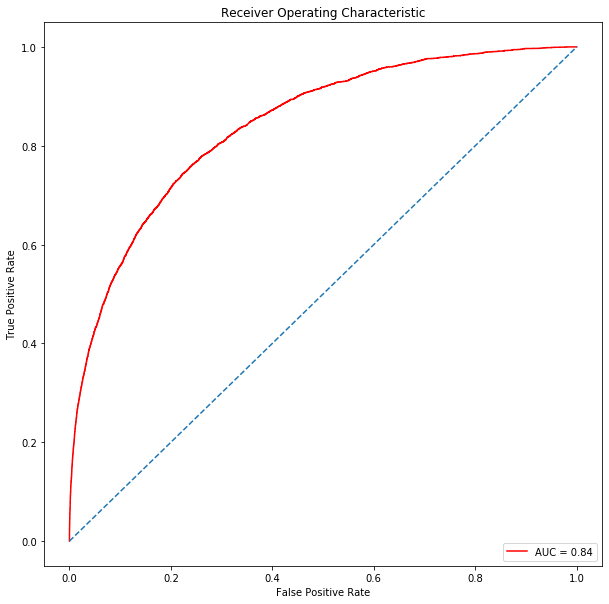

In [61]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [62]:
from sklearn.metrics import classification_report

Text(0, 0.5, 'Frequency')

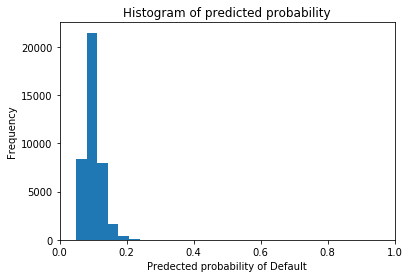

In [63]:
mlp.hist(ypred , bins=8)
mlp.xlim(0,1)
mlp.title("Histogram of predicted probability")
mlp.xlabel("Predected probability of Default")
mlp.ylabel("Frequency")

In [64]:
from sklearn.preprocessing import binarize

In [65]:
ypred_class = binarize([ypred] ,0.2)[0]

C:\Users\kumarvch\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass threshold=0.2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [66]:
print(classification_report(ypred_class , y_valid))

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95     39827
         1.0       0.04      0.90      0.07       173

    accuracy                           0.90     40000
   macro avg       0.52      0.90      0.51     40000
weighted avg       1.00      0.90      0.95     40000



In [67]:
CM=pd.crosstab(ypred_class , y_valid)
CM

target,0,1
row_0,,
0.0,35968,3859
1.0,18,155


In [68]:
TP = CM.iloc[1,1]
TN = CM.iloc[0,0]
FP = CM.iloc[0,1]
FN = CM.iloc[1,0]

In [69]:
#Classification Accuracy: Overall, how often is the classifier correct?
from sklearn import metrics

In [70]:
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_valid, ypred_class))

0.903075
0.903075


In [71]:
#sensitivity or recall score or true positive rate
#When the actual value is positive, how often is the prediction correct?

In [72]:
from sklearn.metrics import precision_score ,recall_score

In [73]:
print(TP / (TP+FN))

print(recall_score(ypred_class , y_valid))

0.8959537572254336
0.8959537572254336
